## all file in 2024
- **Yellow Taxi Trip Records (PARQUET)**
- **Green Taxi Trip Records (PARQUET)**
- **For-Hire Vehicle Trip Records (PARQUET)**
- **High Volume For-Hire Vehicle Trip Records (PARQUET)**


## Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

BASE = "https://d37ci6vzurychx.cloudfront.net/trip-data"
TRIP_TYPES = ["yellow", "green", "fhv", "fhvhv"]  # all four families
MONTHS = list(range(1, 13))
OUTROOT = Path("prod_2024")  # cleaned monthly outputs live here
OUTROOT.mkdir(exist_ok=True)


## Taxi zones (for boroughs later):

In [3]:
# pickup/dropoff zone lookup
zones_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"
zones = pd.read_csv(zones_url)
zones_pu = zones.rename(columns={"LocationID":"pu_location_id"})
zones_do = zones.rename(columns={"LocationID":"do_location_id",
                                 "Borough":"DO_Borough","Zone":"DO_Zone"})


## 1) Canonicalize → Clean (works for Yellow/Green/FHV/HV-FHV)

In [4]:
CANONICAL = {
    # timestamps
    "tpep_pickup_datetime": "pickup_datetime",
    "lpep_pickup_datetime": "pickup_datetime",
    "pickup_datetime": "pickup_datetime",
    "tpep_dropoff_datetime": "dropoff_datetime",
    "lpep_dropoff_datetime": "dropoff_datetime",
    "dropoff_datetime": "dropoff_datetime",

    # locations
    "PULocationID": "pu_location_id",
    "PUlocationID": "pu_location_id",  # FHV sometimes uses lowercase u
    "DOLocationID": "do_location_id",
    "DOlocationID": "do_location_id",

    # distances
    "trip_distance": "trip_distance",
    "trip_miles": "trip_distance",     # FHV uses miles column

    # fares/tips/totals (some sets lack tip/total, we’ll compute when possible)
    "fare_amount": "fare_amount",
    "tip_amount": "tip_amount",
    "total_amount": "total_amount",

    # misc
    "passenger_count": "passenger_count",
    "VendorID": "vendor_id",
    "payment_type": "payment_type",
    "ratecodeid": "rate_code_id", "RatecodeID":"rate_code_id",
    "congestion_surcharge": "congestion_surcharge",
    "Airport_fee": "airport_fee",
}

# columns sometimes present in HVFHV to synthesize totals if missing
HV_POSSIBLE_PARTS = [
    "base_passenger_fare","tolls","bcf","sales_tax",
    "congestion_surcharge","airport_fee","tips","driver_pay"
]

def to_canonical(df: pd.DataFrame, source_type: str) -> pd.DataFrame:
    # rename knowns
    rename = {c: CANONICAL[c] for c in df.columns if c in CANONICAL}
    df = df.rename(columns=rename)
    # coerce datetime/nums if present
    for c in ["pickup_datetime","dropoff_datetime"]:
        if c in df: df[c] = pd.to_datetime(df[c], errors="coerce")
    for c in ["fare_amount","tip_amount","total_amount","trip_distance","passenger_count",
              "congestion_surcharge","airport_fee"]:
        if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")

    # if distance missing but trip_miles existed, it’s already mapped; else fill NaN
    if "trip_distance" not in df: df["trip_distance"] = np.nan
    if "passenger_count" not in df: df["passenger_count"] = np.nan

    # If total_amount missing (common in FHV/HV-FHV), try to synthesize a reasonable total
    if "total_amount" not in df:
        parts = [c for c in HV_POSSIBLE_PARTS if c in df.columns]
        if parts:
            df["total_amount"] = df[parts].sum(axis=1, skipna=True)
        else:
            df["total_amount"] = np.nan

    # If tip_amount missing, set to 0 (most FHV don’t publish tips)
    if "tip_amount" not in df:
        df["tip_amount"] = 0.0

    # Ensure loc IDs exist (for borough join later)
    if "pu_location_id" not in df: df["pu_location_id"] = np.nan
    if "do_location_id" not in df: df["do_location_id"] = np.nan

    df["source_type"] = source_type
    return df


def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # duration (mins) when possible
    if {"pickup_datetime","dropoff_datetime"} <= set(d.columns):
        d["trip_duration_min"] = (d["dropoff_datetime"] - d["pickup_datetime"]).dt.total_seconds()/60
    else:
        d["trip_duration_min"] = np.nan

    # validity (be permissive across types; some fields may be missing)
    valid = pd.Series(True, index=d.index)
    if "fare_amount" in d:
        valid &= (d["fare_amount"].isna()) | (d["fare_amount"] >= 0)
    if "total_amount" in d:
        valid &= (d["total_amount"].isna()) | (d["total_amount"] >= 0)
    if "trip_distance" in d:
        valid &= (d["trip_distance"].isna()) | ((d["trip_distance"] > 0) & (d["trip_distance"] <= 200))
    if "passenger_count" in d:
        valid &= (d["passenger_count"].isna()) | ((d["passenger_count"] >= 1) & (d["passenger_count"] <= 8))
    if "trip_duration_min" in d:
        valid &= d["trip_duration_min"].isna() | d["trip_duration_min"].between(0.1, 360)

    d = d.loc[valid].copy()

    # speed flag (only if duration & distance exist)
    hrs = d["trip_duration_min"]/60
    with np.errstate(divide="ignore", invalid="ignore"):
        d["speed_mph"] = d["trip_distance"] / hrs
    d["speed_flag_gt80"] = d["speed_mph"] > 80

    # temporal features (when pickup exists)
    if "pickup_datetime" in d:
        dt = d["pickup_datetime"]
        d["year"]  = dt.dt.year
        d["month"] = dt.dt.month
        d["day"]   = dt.dt.day
        d["dow"]   = dt.dt.day_name()
        d["hour"]  = dt.dt.hour
    else:
        for c in ["year","month","day","dow","hour"]:
            d[c] = np.nan

    return d


## 2) Stream the year: write cleaned monthly “prod” & accumulate summaries

In [5]:
OUTROOT.mkdir(exist_ok=True)

# summary accumulators (dictionary-of-dictionaries)
by_type = defaultdict(int)                       # total trips per type
by_type_hour = defaultdict(int)                  # (type, hour) -> trips
by_type_dow  = defaultdict(int)                  # (type, dow)  -> trips
by_type_boro = defaultdict(int)                  # (type, borough) -> trips
by_type_air  = defaultdict(int)                  # (type) -> airport trips

for t in TRIP_TYPES:
    outdir = OUTROOT / t
    outdir.mkdir(exist_ok=True)

    for m in MONTHS:
        url = f"{BASE}/{t}_tripdata_2024-{m:02d}.parquet"
        print(f"Processing {t} {m:02d} ... {url}")

        try:
            raw = pd.read_parquet(url)
        except Exception as e:
            print(f"  ⚠️ skip (read failed): {e}")
            continue

        can = to_canonical(raw, t)
        part = clean_df(can)

        # write cleaned monthly prod file
        part.to_parquet(outdir / f"{t}_2024-{m:02d}.parquet", index=False)

        # accumulate summaries (counts only; cheap on memory)
        n = len(part)
        by_type[t] += n

        if "hour" in part:
            c = part.groupby("hour").size()
            for h, v in c.items():
                by_type_hour[(t,int(h))] += int(v)

        if "dow" in part:
            c = part.groupby("dow").size()
            for d, v in c.items():
                by_type_dow[(t,str(d))] += int(v)

        # Borough (pickup side)
        if "pu_location_id" in part:
            mpu = part.merge(zones_pu, on="pu_location_id", how="left")
            c = mpu.groupby("Borough").size()
            for b, v in c.items():
                by_type_boro[(t, str(b))] += int(v)

        # Airport share (when airport_fee present)
        if "airport_fee" in part:
            by_type_air[t] += int((part["airport_fee"] > 0).sum())

print("\n✅ Finished streaming 2024. Cleaned monthly files are in:", OUTROOT)


Processing yellow 01 ... https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet
Processing yellow 02 ... https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet
Processing yellow 03 ... https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet
Processing yellow 04 ... https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-04.parquet
Processing yellow 05 ... https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-05.parquet
Processing yellow 06 ... https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-06.parquet
Processing yellow 07 ... https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-07.parquet
Processing yellow 08 ... https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-08.parquet
Processing yellow 09 ... https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-09.parquet
Processing yellow 10 ... https://d37ci6vzurychx.cloudfr

## 3) Turn the accumulators into DataFrames (view your 2024 results)

In [6]:
# total trips per type
df_type = pd.DataFrame(
    [(t, n) for t, n in by_type.items()], columns=["source_type","trips"]
).sort_values("trips", ascending=False)

# hour × type
df_hour = pd.DataFrame(
    [(t,h,n) for (t,h), n in by_type_hour.items()],
    columns=["source_type","hour","trips"]
).sort_values(["source_type","hour"])

# day-of-week × type
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df_dow = pd.DataFrame(
    [(t,d,n) for (t,d), n in by_type_dow.items()],
    columns=["source_type","dow","trips"]
)
df_dow["dow"] = pd.Categorical(df_dow["dow"], categories=dow_order, ordered=True)
df_dow = df_dow.sort_values(["source_type","dow"])

# borough × type
df_boro = pd.DataFrame(
    [(t,b,n) for (t,b), n in by_type_boro.items()],
    columns=["source_type","borough","trips"]
).sort_values(["source_type","trips"], ascending=[True,False])

# airport share by type (counts + %)
df_air = pd.DataFrame(
    [(t, n_air, by_type[t], n_air/max(by_type[t],1)) for t, n_air in by_type_air.items()],
    columns=["source_type","airport_trips","total_trips","airport_share"]
).sort_values("airport_share", ascending=False)

display(df_type)
display(df_hour.head(20))
display(df_dow.head(20))
display(df_boro.head(20))
display(df_air)


,source_type,trips
3,fhvhv,239423154
0,yellow,39294799
2,fhv,17630326
1,green,613190


,source_type,hour,trips
48,fhv,0,288263
49,fhv,1,200654
50,fhv,2,153539
51,fhv,3,153124
52,fhv,4,253286
53,fhv,5,344859
54,fhv,6,546616
55,fhv,7,940618
56,fhv,8,1236758
57,fhv,9,1383860


,source_type,dow,trips
15,fhv,Monday,2662979
19,fhv,Tuesday,2789875
20,fhv,Wednesday,2813451
18,fhv,Thursday,2775373
14,fhv,Friday,2785328
16,fhv,Saturday,2018263
17,fhv,Sunday,1785057
22,fhvhv,Monday,29837482
26,fhvhv,Tuesday,31252807
27,fhvhv,Wednesday,32449107


,source_type,borough,trips
15,fhv,Brooklyn,998417
18,fhv,Queens,945883
17,fhv,Manhattan,744830
19,fhv,Staten Island,575058
14,fhv,Bronx,309142
16,fhv,EWR,9775
20,fhv,Unknown,70
24,fhvhv,Manhattan,93071394
22,fhvhv,Brooklyn,63160249
25,fhvhv,Queens,50088933


,source_type,airport_trips,total_trips,airport_share
1,fhvhv,20447486,239423154,0.085403
0,yellow,3144571,39294799,0.080025


## 0) Setup (paths, helpers)

In [8]:
import pandas as pd, numpy as np, glob
from pathlib import Path
import pyarrow.parquet as pq

OUTROOT = Path("prod_2024")
TRIP_TYPES = ["yellow","green","fhv","fhvhv"]

ZONES_URL = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"
zones = pd.read_csv(ZONES_URL)
zones_pu = zones.rename(columns={"LocationID":"pu_location_id"})
zones_do = zones.rename(columns={"LocationID":"do_location_id","Borough":"DO_Borough","Zone":"DO_Zone"})

def read_parquet_safe(path, wanted):
    """Read only available columns; add missing ones with NaN/0 where sensible."""
    schema_cols = set(pq.ParquetFile(path).schema_arrow.names)
    cols_to_read = [c for c in wanted if c in schema_cols]
    df = pd.read_parquet(path, columns=cols_to_read)

    for c in wanted:
        if c not in df.columns:
            if c in {"fare_amount","total_amount","tip_amount","trip_distance","airport_fee","trip_duration_min"}:
                df[c] = np.nan
            elif c in {"pu_location_id","do_location_id"}:
                df[c] = pd.Series(dtype="float64")
            elif c == "pickup_datetime":
                df[c] = pd.to_datetime(pd.NaT)
            elif c == "speed_flag_gt80":
                df[c] = False
            elif c == "source_type":
                name = str(path)
                df[c] = ("yellow" if "yellow_" in name else
                         "green"  if "green_"  in name else
                         "fhvhv"  if "fhvhv_"  in name else
                         "fhv"    if "fhv_"    in name else "unknown")
            else:
                df[c] = pd.NA
    return df[wanted]


## 1) Heatmaps: Hour × Day-of-week per type (population counts)

In [9]:
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
agg_rows = []

for t in TRIP_TYPES:
    for p in sorted((OUTROOT/t).glob(f"{t}_2024-*.parquet")):
        df = read_parquet_safe(p, wanted=["pickup_datetime","source_type"])
        ts = pd.to_datetime(df["pickup_datetime"], errors="coerce")
        part = (pd.DataFrame({
                    "source_type": t,
                    "hour": ts.dt.hour,
                    "dow": ts.dt.day_name()
                })
                .value_counts(["source_type","dow","hour"])
                .rename("trips")
                .reset_index())
        agg_rows.append(part)

df_dow_hour = (pd.concat(agg_rows, ignore_index=True)
               .groupby(["source_type","dow","hour"], as_index=False)["trips"].sum())
df_dow_hour["dow"] = pd.Categorical(df_dow_hour["dow"], categories=dow_order, ordered=True)
df_dow_hour = df_dow_hour.sort_values(["source_type","dow","hour"])
df_dow_hour.head()


,source_type,dow,hour,trips
24,fhv,Monday,0,38608
25,fhv,Monday,1,26324
26,fhv,Monday,2,20581
27,fhv,Monday,3,21850
28,fhv,Monday,4,39796


In [10]:
rows = []
for t in TRIP_TYPES:
    for p in sorted((OUTROOT/t).glob(f"{t}_2024-*.parquet")):
        df = read_parquet_safe(p, wanted=[
            "pickup_datetime","trip_distance","fare_amount","total_amount",
            "tip_amount","airport_fee","trip_duration_min","source_type"
        ])
        df["airport"] = df["airport_fee"].fillna(0) > 0
        # fare per mile (safe divide)
        df["fare_per_mile"] = np.where(df["trip_distance"]>0, df["fare_amount"]/df["trip_distance"], np.nan)
        gb = (df.groupby("airport")
                .agg(trips=("airport","size"),
                     fare_pm_median=("fare_per_mile","median"),
                     duration_median=("trip_duration_min","median"),
                     tip_rate_median=("tip_amount","median"))  # tip rate not always available; use median tip $
                .reset_index())
        gb["source_type"] = t
        rows.append(gb)

air_cmp = (pd.concat(rows, ignore_index=True)
           .sort_values(["source_type","airport"], ascending=[True,False]))
air_cmp


,airport,trips,fare_pm_median,duration_median,tip_rate_median,source_type
36,False,1290116,NaN,NaN,0.00,fhv
37,False,1176093,NaN,NaN,0.00,fhv
38,False,1469352,NaN,NaN,0.00,fhv
39,False,1444626,NaN,NaN,0.00,fhv
40,False,1352502,NaN,NaN,0.00,fhv
...,...,...,...,...,...,...
14,False,2568228,7.407407,11.900000,2.50,yellow
16,False,3166984,7.741935,13.066667,2.52,yellow
18,False,3345480,7.815126,13.050000,2.66,yellow
20,False,3224249,7.818182,12.716667,2.60,yellow


## Step 1 — Confirm all types are present

In [11]:
df_dow_hour["source_type"].value_counts()
df_dow_hour.groupby("source_type").size()
list(df_dow_hour["source_type"].unique())


['fhv', 'fhvhv', 'green', 'yellow']

## Step 2 — Peek each type explicitly

In [12]:
for t in ["yellow","green","fhv","fhvhv"]:
    print("\n===", t, "===")
    display(df_dow_hour[df_dow_hour["source_type"]==t].head())



=== yellow ===


,source_type,dow,hour,trips
528,yellow,Monday,0,84330
529,yellow,Monday,1,43668
530,yellow,Monday,2,25802
531,yellow,Monday,3,19089
532,yellow,Monday,4,23091



=== green ===


,source_type,dow,hour,trips
360,green,Monday,0,1226
361,green,Monday,1,762
362,green,Monday,2,515
363,green,Monday,3,337
364,green,Monday,4,314



=== fhv ===


,source_type,dow,hour,trips
24,fhv,Monday,0,38608
25,fhv,Monday,1,26324
26,fhv,Monday,2,20581
27,fhv,Monday,3,21850
28,fhv,Monday,4,39796



=== fhvhv ===


,source_type,dow,hour,trips
192,fhvhv,Monday,0,977139
193,fhvhv,Monday,1,613504
194,fhvhv,Monday,2,427315
195,fhvhv,Monday,3,368675
196,fhvhv,Monday,4,466476


## Step 3 — Sort in a human order so .head() starts with Yellow

In [13]:
type_order = pd.CategoricalDtype(categories=["yellow","green","fhv","fhvhv"], ordered=True)
df_dow_hour["source_type"] = df_dow_hour["source_type"].astype(type_order)
df_dow_hour = df_dow_hour.sort_values(["source_type","dow","hour"])
df_dow_hour.head()   # now starts with yellow


,source_type,dow,hour,trips
528,yellow,Monday,0,84330
529,yellow,Monday,1,43668
530,yellow,Monday,2,25802
531,yellow,Monday,3,19089
532,yellow,Monday,4,23091


In [14]:
# Just Yellow rows
yellow_dh = df_dow_hour.query("source_type == 'yellow'")
display(yellow_dh.head())

# Heatmap-friendly pivot for Yellow
p = (yellow_dh.pivot(index="dow", columns="hour", values="trips")
               .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]))
display(p)


,source_type,dow,hour,trips
528,yellow,Monday,0,84330
529,yellow,Monday,1,43668
530,yellow,Monday,2,25802
531,yellow,Monday,3,19089
532,yellow,Monday,4,23091


hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
dow,,,,,,,,,,,,,,,,,,,,,
Monday,84330,43668,25802,19089,23091,39310,91093,174196,233627,237324,...,314916,324799,317204,346236,352589,293402,279715,275064,215962,138147
Tuesday,74267,31274,14854,9806,14149,34773,91483,196750,273195,275492,...,335622,347636,347120,396511,426727,364614,358898,380519,315423,190256
Wednesday,89976,38448,19732,13031,15427,34734,93407,202191,277047,276989,...,339945,354188,359504,411584,441008,381311,366836,393426,345132,217427
Thursday,111585,51909,27369,18166,19498,39213,98698,204444,278497,280947,...,349251,365774,371767,424981,457761,398537,380742,401099,381041,286561
Friday,173998,89556,50254,31395,28168,40547,88267,168805,220233,233533,...,343606,360584,353944,387857,419432,384872,316561,319235,342455,330708
Saturday,290671,227708,163642,101628,55559,26382,45951,70065,114260,175525,...,324338,344272,365365,380682,393990,382873,322397,318939,355509,357543
Sunday,309307,250044,173398,116576,69443,31905,46864,67080,100863,160419,...,320925,308277,316340,317194,305064,264450,239529,223988,182379,133582


## Step 1 — lock in a friendly sort order

In [15]:
import pandas as pd

type_order = pd.CategoricalDtype(categories=["yellow","green","fhv","fhvhv"], ordered=True)
dow_order  = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

df_dow_hour["source_type"] = df_dow_hour["source_type"].astype(type_order)
df_dow_hour["dow"] = pd.Categorical(df_dow_hour["dow"], categories=dow_order, ordered=True)
df_dow_hour = df_dow_hour.sort_values(["source_type","dow","hour"])


## Step 2 — make a heatmap helper (matplotlib only)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def heatmap_type(dh, t, title_suffix="(2024)"):
    """dh = df_dow_hour; t = 'yellow'|'green'|'fhv'|'fhvhv'"""
    block = dh[dh["source_type"]==t]
    pivot = (block.pivot(index="dow", columns="hour", values="trips")
                  .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]))
    plt.figure(figsize=(9,4))
    plt.imshow(pivot.values, aspect="auto")
    plt.title(f"{t.upper()} — Trips by Day × Hour {title_suffix}")
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(24), range(24))
    plt.colorbar(label="Trips")
    plt.tight_layout()
    plt.show()
    return pivot  # handy if you want to save/export later


## Step 3 — plot Yellow first

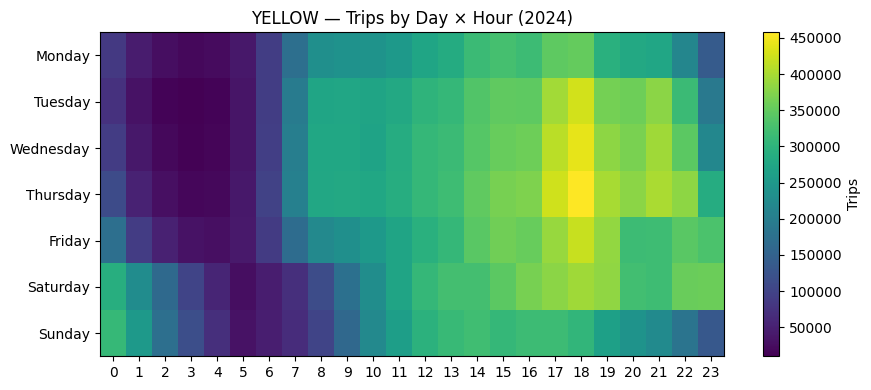

In [17]:
yellow_pivot = heatmap_type(df_dow_hour, "yellow")


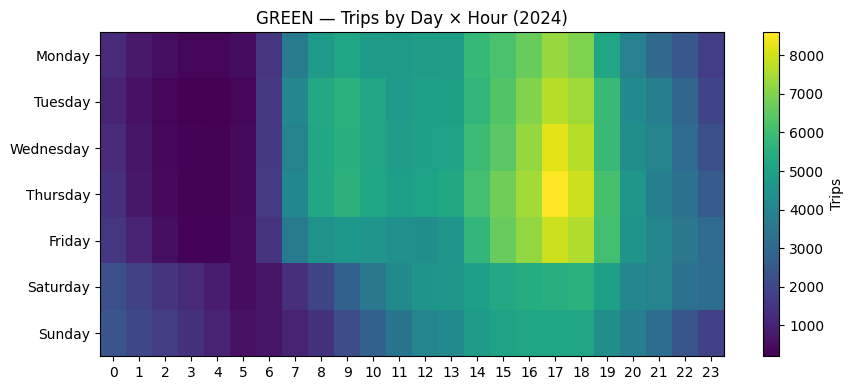

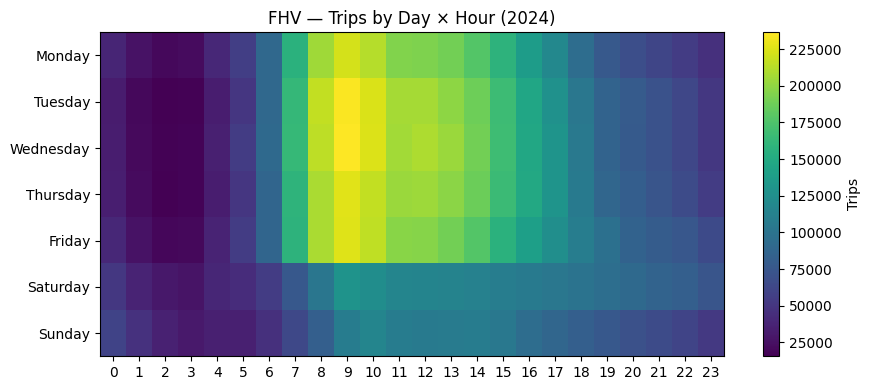

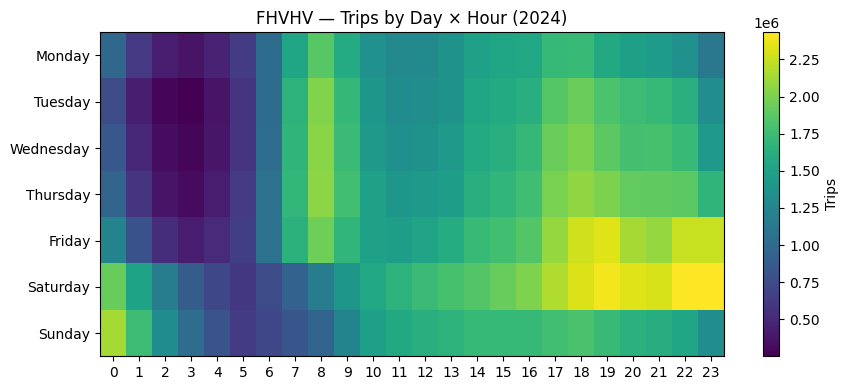

In [18]:
green_pivot  = heatmap_type(df_dow_hour, "green")
fhv_pivot    = heatmap_type(df_dow_hour, "fhv")
hv_pivot     = heatmap_type(df_dow_hour, "fhvhv")


## Step 4 — (optional) normalize to percentages (easier cross-type comparison)

In [22]:
def heatmap_type_percent(dh, t):
    block = dh[dh["source_type"]==t]
    pivot = (block.pivot(index="dow", columns="hour", values="trips")
                  .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]))
    pct = pivot / pivot.values.sum() * 100.0
    plt.figure(figsize=(9,4))
    plt.imshow(pct.values, aspect="auto")
    plt.title(f"{t.upper()} — Share of Weekly Trips by Day × Hour (%, 2024)")
    plt.yticks(range(len(pct.index)), pct.index)
    plt.xticks(range(24), range(24))
    plt.colorbar(label="% of trips")
    plt.tight_layout()
    plt.show()
    return pct




=== YELLOW ===


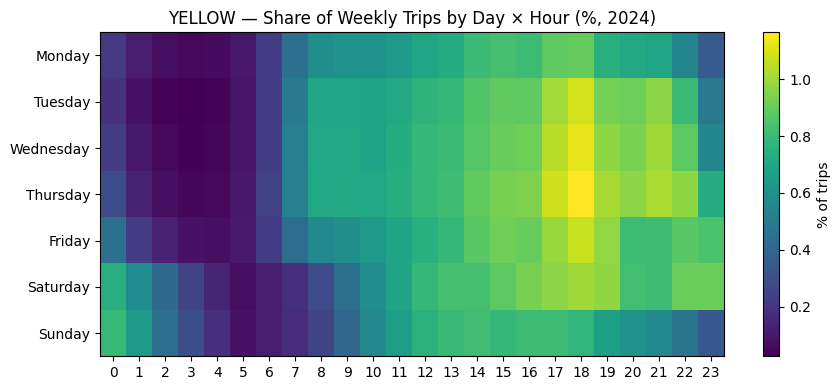


=== GREEN ===


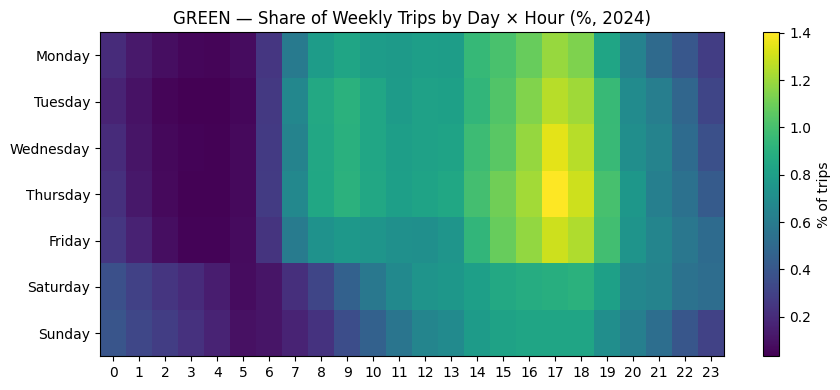


=== FHV ===


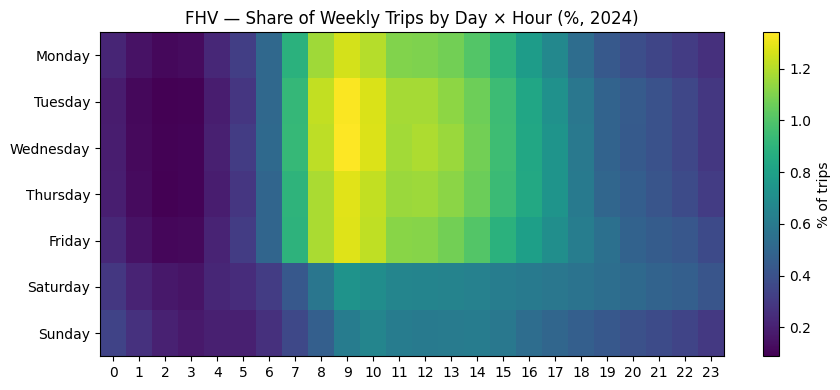


=== FHVHV ===


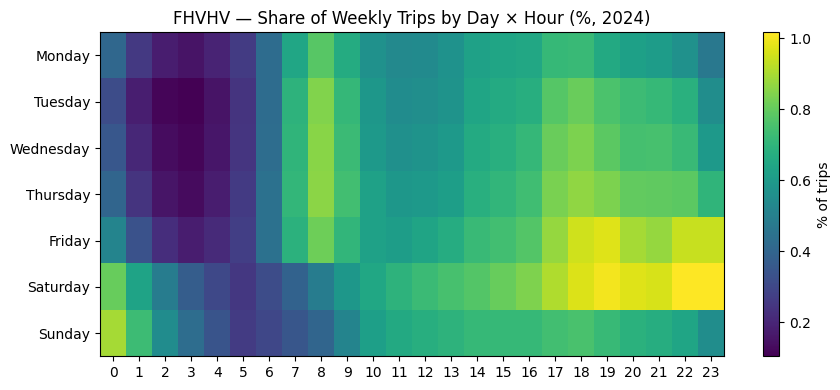

In [23]:
# Render percent heatmaps for all types (one-by-one) and save the pivot tables
types = ["yellow","green","fhv","fhvhv"]
pivots_pct = {}

for t in types:
    print(f"\n=== {t.upper()} ===")
    piv = heatmap_type_percent(df_dow_hour, t)  # uses your function
    pivots_pct[t] = piv
    piv.to_csv(f"{t}_2024_day_hour_share.csv")


## 4) (Optional) Build one all-2024 DataFrame per type or combined

In [ ]:
import glob

# Example: build an annual YELLOW dataset from cleaned parts
yellow_parts = sorted(glob.glob(str((OUTROOT/"yellow") / "yellow_2024-*.parquet")))
yellow_2024 = pd.concat([pd.read_parquet(p) for p in yellow_parts], ignore_index=True)
print("yellow_2024 shape:", yellow_2024.shape)

# Or build a combined ALL-TYPES dataset with a loop (careful with memory!)
all_cleaned = []
for t in TRIP_TYPES:
    parts = sorted(glob.glob(str((OUTROOT/t) / f"{t}_2024-*.parquet")))
    if not parts: continue
    tmp = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)
    tmp["source_type"] = t
    all_cleaned.append(tmp)
df_all_2024 = pd.concat(all_cleaned, ignore_index=True)
print("df_all_2024 shape:", df_all_2024.shape)


yellow_2024 shape: (39294799, 28)


## 🧭 1. Verify totals (sanity check)

In [4]:
from pathlib import Path
import pandas as pd

OUTROOT = Path("prod_2024")
TRIP_TYPES = ["yellow","green","fhv","fhvhv"]

for t in TRIP_TYPES:
    files = sorted((OUTROOT / t).glob(f"{t}_2024-*.parquet"))
    n = sum(len(pd.read_parquet(p, columns=["pickup_datetime"])) for p in files)
    print(f"{t:7s}: {n:,} rows  ({len(files)} monthly files)")


yellow : 39,294,799 rows  (12 monthly files)
green  : 613,190 rows  (12 monthly files)
fhv    : 17,630,326 rows  (12 monthly files)
fhvhv  : 239,423,154 rows  (12 monthly files)


## 📊 2. Load everything into a unified, light DataFrame

In [6]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path
import glob

WANTED = [
    "pickup_datetime","trip_distance","fare_amount","total_amount","tip_amount",
    "pu_location_id","do_location_id","airport_fee","source_type"
]

def read_parquet_safe(path: str, wanted=WANTED) -> pd.DataFrame:
    """Read only available columns; add any missing columns with NaN."""
    schema_cols = set(pq.ParquetFile(path).schema_arrow.names)
    cols_to_read = [c for c in wanted if c in schema_cols]
    df = pd.read_parquet(path, columns=cols_to_read)

    # add back any missing columns
    for c in wanted:
        if c not in df.columns:
            # sensible defaults
            if c in {"fare_amount","total_amount","tip_amount","trip_distance","airport_fee"}:
                df[c] = np.nan
            elif c in {"pu_location_id","do_location_id"}:
                df[c] = pd.Series(dtype="float64")
            elif c == "pickup_datetime":
                df[c] = pd.to_datetime(pd.NaT)
            elif c == "source_type":
                # infer from folder/file name if possible
                if "yellow_" in path: df[c] = "yellow"
                elif "green_" in path: df[c] = "green"
                elif "fhvhv_" in path: df[c] = "fhvhv"
                elif "fhv_" in path: df[c] = "fhv"
                else: df[c] = "unknown"
            else:
                df[c] = pd.NA
    # return in a consistent column order
    return df[wanted]


## 2) Rebuild your “all 2024” sample using the safe reader

In [7]:
OUTROOT = Path("prod_2024")
TRIP_TYPES = ["yellow","green","fhv","fhvhv"]
SAMPLE_PER_FILE = 50_000    # adjust to your RAM

def sample_or_agg_safe(t, n_sample=SAMPLE_PER_FILE):
    files = sorted(glob.glob(str(OUTROOT / t / f"{t}_2024-*.parquet")))
    pieces = []
    for f in files:
        df = read_parquet_safe(f)
        if len(df) > n_sample:
            df = df.sample(n_sample, random_state=42)
        pieces.append(df)
    return pd.concat(pieces, ignore_index=True) if pieces else pd.DataFrame(columns=WANTED)

df_all_2024 = pd.concat([sample_or_agg_safe(t) for t in TRIP_TYPES], ignore_index=True)
print("Combined sample shape:", df_all_2024.shape)
df_all_2024.head()


Combined sample shape: (2393830, 9)


,pickup_datetime,trip_distance,fare_amount,total_amount,tip_amount,pu_location_id,do_location_id,airport_fee,source_type
0,2024-01-24 11:41:33,17.8,70.0,97.15,16.15,230.0,132.0,0.00,yellow
1,2024-01-29 10:19:29,11.1,49.9,80.76,13.17,138.0,161.0,1.75,yellow
2,2024-01-13 10:32:40,1.8,11.4,15.40,0.00,230.0,237.0,0.00,yellow
3,2024-01-23 09:21:05,0.9,9.3,15.95,2.65,141.0,229.0,0.00,yellow
4,2024-01-20 15:56:27,3.2,20.5,27.00,2.50,166.0,237.0,0.00,yellow


## A) Monthly deltas: raw vs cleaned (fast, metadata-only)

In [27]:
import pandas as pd, numpy as np
from pathlib import Path
import pyarrow.parquet as pq

# 1) helper that reads the Parquet footer over HTTPS (very light)
def raw_num_rows(url: str) -> int | None:
    try:
        import fsspec  # needs to be installed once: pip install fsspec
        with fsspec.open(url, "rb") as f:
            return pq.ParquetFile(f).metadata.num_rows
    except Exception as e:
        print("raw_num_rows failed for", url, ":", e)
        return None

BASE = "https://d37ci6vzurychx.cloudfront.net/trip-data"
OUTROOT = Path("prod_2024")
TRIP_TYPES = ["yellow","green","fhv","fhvhv"]
MONTHS = list(range(1,13))

rows = []
for t in TRIP_TYPES:
    for m in MONTHS:
        url = f"{BASE}/{t}_tripdata_2024-{m:02d}.parquet"
        cleaned_path = OUTROOT / t / f"{t}_2024-{m:02d}.parquet"

        raw_rows = raw_num_rows(url)

        if cleaned_path.exists():
            try:
                cln_pf = pq.ParquetFile(cleaned_path)
                cleaned_rows = cln_pf.metadata.num_rows
            except Exception:
                cleaned_rows = None
        else:
            cleaned_rows = None

        rows.append({
            "source_type": t,
            "month": m,
            "raw_rows": raw_rows,
            "cleaned_rows": cleaned_rows,
        })

df_delta_monthly = pd.DataFrame(rows)

# 2) do safe numeric math
df_delta_monthly["raw_rows"] = pd.to_numeric(df_delta_monthly["raw_rows"], errors="coerce")
df_delta_monthly["cleaned_rows"] = pd.to_numeric(df_delta_monthly["cleaned_rows"], errors="coerce")

df_delta_monthly["removed_rows"] = df_delta_monthly["raw_rows"] - df_delta_monthly["cleaned_rows"]
df_delta_monthly["kept_pct"]    = df_delta_monthly["cleaned_rows"] / df_delta_monthly["raw_rows"]
df_delta_monthly["removed_pct"] = 1 - df_delta_monthly["kept_pct"]

df_delta_monthly = df_delta_monthly.sort_values(["source_type","month"]).reset_index(drop=True)
display(df_delta_monthly.head(20))


raw_num_rows failed for https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet : No module named 'fsspec'
raw_num_rows failed for https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet : No module named 'fsspec'
raw_num_rows failed for https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet : No module named 'fsspec'
raw_num_rows failed for https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-04.parquet : No module named 'fsspec'
raw_num_rows failed for https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-05.parquet : No module named 'fsspec'
raw_num_rows failed for https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-06.parquet : No module named 'fsspec'
raw_num_rows failed for https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-07.parquet : No module named 'fsspec'
raw_num_rows failed for https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_trip

,source_type,month,raw_rows,cleaned_rows,removed_rows,kept_pct,removed_pct
0,fhv,1,NaN,1290116,NaN,NaN,NaN
1,fhv,2,NaN,1176093,NaN,NaN,NaN
2,fhv,3,NaN,1469352,NaN,NaN,NaN
3,fhv,4,NaN,1444626,NaN,NaN,NaN
4,fhv,5,NaN,1352502,NaN,NaN,NaN
5,fhv,6,NaN,1386539,NaN,NaN,NaN
6,fhv,7,NaN,1382739,NaN,NaN,NaN
7,fhv,8,NaN,1484471,NaN,NaN,NaN
8,fhv,9,NaN,1718375,NaN,NaN,NaN
9,fhv,10,NaN,1421231,NaN,NaN,NaN


## 1) Robust raw row counter

In [29]:
# If needed (run once):
# !pip install fsspec pyarrow

import pandas as pd, numpy as np
from pathlib import Path
import pyarrow.parquet as pq

BASE = "https://d37ci6vzurychx.cloudfront.net/trip-data"
OUTROOT = Path("prod_2024")
TRIP_TYPES = ["yellow","green","fhv","fhvhv"]
MONTHS = list(range(1,13))

def raw_num_rows(url: str):
    """Return total rows in a remote Parquet file on CloudFront.
       Tries footer-only via fsspec+pyarrow, falls back to reading one column."""
    # A) footer-only (cheap)
    try:
        import fsspec
        with fsspec.open(url, "rb") as f:
            return pq.ParquetFile(f).metadata.num_rows
    except Exception:
        pass
    # B) fallback: read one column & count (range-requests; reads only that column)
    try:
        df = pd.read_parquet(url, columns=["pickup_datetime"])
        return len(df)
    except Exception as e:
        print("raw_num_rows fallback failed:", url, e)
        return np.nan


## 2) Monthly raw vs cleaned table (safe arithmetic)

In [32]:
import pandas as pd, numpy as np
from pathlib import Path
import pyarrow.parquet as pq

BASE = "https://d37ci6vzurychx.cloudfront.net/trip-data"
OUTROOT = Path("prod_2024")
TRIP_TYPES = ["yellow","green","fhv","fhvhv"]
MONTHS = list(range(1,13))

# Which pickup column to try for each source_type
DT_COLS = {
    "yellow": ["tpep_pickup_datetime"],
    "green" : ["lpep_pickup_datetime"],
    "fhv"   : ["pickup_datetime", "Pickup_DateTime"],
    "fhvhv" : ["pickup_datetime"],
}
# Fallback order if type key is missing
DT_FALLBACK = ["pickup_datetime", "tpep_pickup_datetime", "lpep_pickup_datetime"]

def raw_num_rows(url: str, source_type: str):
    """Return row count of remote Parquet. Try footer-only via fsspec, else
       read a single existing datetime column and count rows."""
    # A) Footer-only (cheap) if fsspec is available
    try:
        import fsspec
        with fsspec.open(url, "rb") as f:
            return pq.ParquetFile(f).metadata.num_rows
    except Exception:
        pass

    # B) Minimal column read (try candidates for this type, then fallbacks)
    candidates = DT_COLS.get(source_type, []) + DT_FALLBACK
    tried = set()
    for col in candidates:
        if col in tried: 
            continue
        tried.add(col)
        try:
            df = pd.read_parquet(url, columns=[col])
            return len(df)
        except Exception:
            continue

    # C) Give up
    return np.nan

# ---- Build monthly before/after table ----
rows = []
for t in TRIP_TYPES:
    for m in MONTHS:
        url = f"{BASE}/{t}_tripdata_2024-{m:02d}.parquet"
        cleaned_path = OUTROOT / t / f"{t}_2024-{m:02d}.parquet"

        raw_rows = raw_num_rows(url, t)

        cleaned_rows = np.nan
        if cleaned_path.exists():
            try:
                cleaned_rows = pq.ParquetFile(cleaned_path).metadata.num_rows
            except Exception:
                pass

        rows.append({"source_type": t, "month": m,
                     "raw_rows": raw_rows, "cleaned_rows": cleaned_rows})

df_delta_monthly = pd.DataFrame(rows)

# numeric & safe arithmetic
for c in ["raw_rows","cleaned_rows"]:
    df_delta_monthly[c] = pd.to_numeric(df_delta_monthly[c], errors="coerce")

df_delta_monthly["removed_rows"] = df_delta_monthly["raw_rows"] - df_delta_monthly["cleaned_rows"]
df_delta_monthly["kept_pct"]    = df_delta_monthly["cleaned_rows"] / df_delta_monthly["raw_rows"]
df_delta_monthly["removed_pct"] = 1 - df_delta_monthly["kept_pct"]

df_delta_monthly = df_delta_monthly.sort_values(["source_type","month"]).reset_index(drop=True)
display(df_delta_monthly.head(24))

# ---- Type totals + grand total ----
by_type_totals = (df_delta_monthly
    .groupby("source_type", as_index=False, dropna=False)
    .agg(raw_rows=("raw_rows","sum"),
         cleaned_rows=("cleaned_rows","sum"),
         removed_rows=("removed_rows","sum"))
)
by_type_totals["kept_pct"]    = by_type_totals["cleaned_rows"] / by_type_totals["raw_rows"]
by_type_totals["removed_pct"] = 1 - by_type_totals["kept_pct"]

display(by_type_totals.sort_values("cleaned_rows", ascending=False))

grand = by_type_totals[["raw_rows","cleaned_rows","removed_rows"]].sum(numeric_only=True)
grand_kept = grand["cleaned_rows"] / grand["raw_rows"]
print(
    f"ALL TYPES 2024 — raw: {grand['raw_rows']:,} | "
    f"cleaned: {grand['cleaned_rows']:,} | "
    f"removed: {grand['removed_rows']:,} | kept: {grand_kept:.2%}"
)

# (optional) persist for your report
df_delta_monthly.to_csv("delta_2024_monthly_raw_vs_cleaned.csv", index=False)
by_type_totals.to_csv("delta_2024_type_totals_raw_vs_cleaned.csv", index=False)


,source_type,month,raw_rows,cleaned_rows,removed_rows,kept_pct,removed_pct
0,fhv,1,1290116,1290116,0,1.000000,0.000000
1,fhv,2,1176093,1176093,0,1.000000,0.000000
2,fhv,3,1469352,1469352,0,1.000000,0.000000
3,fhv,4,1444626,1444626,0,1.000000,0.000000
4,fhv,5,1352502,1352502,0,1.000000,0.000000
5,fhv,6,1386539,1386539,0,1.000000,0.000000
6,fhv,7,1382739,1382739,0,1.000000,0.000000
7,fhv,8,1484471,1484471,0,1.000000,0.000000
8,fhv,9,1718375,1718375,0,1.000000,0.000000
9,fhv,10,1421231,1421231,0,1.000000,0.000000


,source_type,raw_rows,cleaned_rows,removed_rows,kept_pct,removed_pct
1,fhvhv,239470448,239423154,47294,0.999803,0.000197
3,yellow,41169720,39294799,1874921,0.954459,0.045541
0,fhv,17630326,17630326,0,1.000000,0.000000
2,green,660218,613190,47028,0.928769,0.071231


ALL TYPES 2024 — raw: 298,930,712 | cleaned: 296,961,469 | removed: 1,969,243 | kept: 99.34%
